# Movie Recommendation

### IMDB movie recommendation notebook

In [1]:
!unzip /content/drive/MyDrive/Sentiment_Analysis/movies_data.zip -d /content/drive/MyDrive/Sentiment-Analysis

Archive:  /content/drive/MyDrive/Sentiment_Analysis/movies_data.zip
  inflating: /content/drive/MyDrive/Sentiment-Analysis/tmdb_movies_data.csv  


In [98]:
import pandas as pd
import json
import os
from sklearn.model_selection import train_test_split

# Read CSV file
movies = pd.read_csv('/content/drive/MyDrive/Sentiment-Analysis/tmdb_movies_data.csv')

def split_pipe(x):
    if pd.isna(x) or x == "":
        return []
    return [item.strip() for item in x.split('|')]

for col in ['genres', 'cast', 'keywords']:
    if col in movies.columns:
        movies[col] = movies[col].apply(split_pipe)

if 'vote_count' in movies.columns:
    movies['vote_count'] = (
        movies['vote_count']
        .astype(str)
        .str.replace(',', '', regex=False)
        .astype(float)
        .fillna(0)
        .astype(int)    # Finally to int
    )

if 'vote_average' in movies.columns:
    movies['vote_average'] = pd.to_numeric(movies['vote_average'], errors='coerce').fillna(0)

train_df, test_df = train_test_split(movies, test_size=0.25, random_state=42)

train_data = train_df.to_dict(orient='records')
test_data = test_df.to_dict(orient='records')

output_dir = '/content/drive/MyDrive/Sentiment-Analysis/json_output'
os.makedirs(output_dir, exist_ok=True)

train_json_path = os.path.join(output_dir, 'train_movies.json')
test_json_path = os.path.join(output_dir, 'test_movies.json')

with open(train_json_path, 'w', encoding='utf-8') as f:
    json.dump(train_data, f, ensure_ascii=False, indent=4)

with open(test_json_path, 'w', encoding='utf-8') as f:
    json.dump(test_data, f, ensure_ascii=False, indent=4)

print(f"JSON files created successfully:\n{train_json_path}\n{test_json_path}")


JSON files created successfully:
/content/drive/MyDrive/Sentiment-Analysis/json_output/train_movies.json
/content/drive/MyDrive/Sentiment-Analysis/json_output/test_movies.json


In [2]:
# Imports

# General

import os
import re
import pandas as pd
import numpy as np
import random
import pickle

# graphs

from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# Model
# sklearn
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.feature_extraction import text

In [3]:
from matplotlib import pyplot as plt

In [5]:
train = pd.read_json("/content/drive/MyDrive/Sentiment-Analysis/json_output/train_movies.json")
test = pd.read_json("/content/drive/MyDrive/Sentiment-Analysis/json_output/test_movies.json")

In [5]:
train.keys()

Index(['id', 'imdb_id', 'popularity', 'budget', 'revenue', 'original_title',
       'cast', 'homepage', 'director', 'tagline', 'keywords', 'overview',
       'runtime', 'genres', 'production_companies', 'release_date',
       'vote_count', 'vote_average', 'release_year', 'budget_adj',
       'revenue_adj'],
      dtype='object')

In [6]:
test.keys()

Index(['id', 'imdb_id', 'popularity', 'budget', 'revenue', 'original_title',
       'cast', 'homepage', 'director', 'tagline', 'keywords', 'overview',
       'runtime', 'genres', 'production_companies', 'release_date',
       'vote_count', 'vote_average', 'release_year', 'budget_adj',
       'revenue_adj'],
      dtype='object')

In [7]:
test.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,11674,tt0115433,1.419885,54000000,320689294,101 Dalmatians,"[Glenn Close, Jeff Daniels, Joely Richardson, ...",None,Stephen Herek,So many dogs. So little time.,...,The Live action adaptation of a Disney Classic...,103,"[Comedy, Family]",Walt Disney Pictures|Great Oaks Entertainment,11/17/1996,367,5.5,1996,7.507170e+07,4.458276e+08
1,26505,tt0940657,0.691392,87000000,0,Arthur et la vengeance de Maltazard,"[Freddie Highmore, Mia Farrow, Logan Miller, R...",None,Luc Besson,None,...,Arthur answers a distress call from Princess S...,93,"[Adventure, Fantasy, Animation, Family]",Sofica Europacorp|ApipoulaÃ¯|Avalanche Product...,11/26/2009,196,5.3,2009,8.842684e+07,0.000000e+00
2,644,tt0212720,2.971372,100000000,235926552,A.I. Artificial Intelligence,"[Haley Joel Osment, Frances O'Connor, Sam Roba...",None,Steven Spielberg,Journey to a world where robots dream and desire.,...,"11-year-old David, the first android with huma...",146,"[Drama, Science Fiction, Adventure]",DreamWorks SKG|Amblin Entertainment|Stanley Ku...,6/29/2001,1133,6.6,2001,1.231488e+08,2.905407e+08
3,12143,tt0103759,0.851712,1000000,2019469,Bad Lieutenant,"[Harvey Keitel, Victor Argo, Frankie Thorn, Ro...",None,Abel Ferrara,Gambler. Thief. Junkie. Killer. Cop.,...,"While investigating a young nun's rape, a corr...",96,"[Crime, Drama]",Bad Lt. Productions,9/16/1992,63,6.3,1992,1.554024e+06,3.138304e+06
4,37565,tt1210106,0.300920,0,0,St Trinian's 2: The Legend of Fritton's Gold,"[Talulah Riley, Rupert Everett, Gemma Arterton...",None,Oliver Parker|Barnaby Thompson,None,...,The girls of St. Trinians are on the hunt for ...,106,"[Comedy, Adventure]",Ealing Studios,12/18/2009,46,5.1,2009,0.000000e+00,0.000000e+00


In [8]:
train.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,15139,tt0110763,0.776380,27000000,13670688,The Pagemaster,"[Macaulay Culkin, Christopher Lloyd, Patrick S...",None,Pixote Hunt|Joe Johnston|Maurice Hunt,All The Adventure Your Imagination Can Hold.,...,"Tyler knows a lot about accidents. So much so,...",80,"[Fantasy, Science Fiction, Family, Animation]",20th Century Fox|Turner Pictures,11/23/1994,91,6.5,1994,39720012.16,2.011111e+07
1,224972,tt3983674,0.114264,0,0,The Mask You Live In,[],http://themaskyoulivein.org,Jennifer Siebel Newsom,"Is american masculinity harming our boys, men ...",...,"Compared to girls, research shows that boys in...",88,[Documentary],None,1/1/2015,11,8.9,2015,0.00,0.000000e+00
2,72545,tt1397514,1.814197,79000000,355692760,Journey 2: The Mysterious Island,"[Dwayne Johnson, Josh Hutcherson, Kristin Davi...",http://www.themysteriousisland.com/,Brad Peyton,Believe the Impossible. Discover the Incredible.,...,Sean Anderson partners with his mom's boyfrien...,94,"[Adventure, Action, Science Fiction]",New Line Cinema|Contrafilm|Walden Media,1/19/2012,601,5.8,2012,75029798.23,3.378172e+08
3,10464,tt0109484,0.391182,0,0,"Corrina, Corrina","[Whoopi Goldberg, Ray Liotta, Tina Majorino, J...",None,Jessie Nelson,None,...,"When Manny Singer's wife dies, his young daugh...",115,"[Comedy, Drama, Family, Romance]",New Line Cinema,8/12/1994,34,6.4,1994,0.00,0.000000e+00
4,12244,tt0472033,2.846465,30000000,48428063,9,"[Elijah Wood, John C. Reilly, Jennifer Connell...",None,Shane Acker,When our world ended their mission began.,...,"When 9 first comes to life, he finds himself i...",79,"[Action, Adventure, Animation, Science Fiction...",Focus Films|Starz Animation|Relativity Media|T...,8/19/2009,851,6.5,2009,30492013.02,4.922230e+07


In [9]:
combined = pd.concat([train, test], ignore_index=True)
movies = combined[["imdb_id", "original_title", "vote_average", "vote_count", "genres"]].dropna()
movies.drop_duplicates(subset=['imdb_id'], keep=False, inplace=True)

In [10]:
movies.tail()

,imdb_id,original_title,vote_average,vote_count,genres
10861,tt2113636,Colt 45,5.3,47,"[Drama, Thriller, Action, Crime]"
10862,tt0119951,Private Parts,6.6,38,"[Comedy, Drama]"
10863,tt2182972,Song One,5.7,58,[Drama]
10864,tt0062512,You Only Live Twice,6.2,301,"[Action, Thriller, Adventure]"
10865,tt1399103,Transformers: Dark of the Moon,6.1,2456,"[Action, Science Fiction, Adventure]"


In [11]:
movies.shape

(10854, 5)

### Encoding genres

In [12]:
# Flatten all genres and remove spaces
genres = set(
    j.replace(" ", "")
    for sublist in movies['genres']  # each row is already a list
    for j in sublist
)
print(genres)
print(len(genres))


{'Thriller', 'Fantasy', 'History', 'Foreign', 'Horror', 'Family', 'War', 'ScienceFiction', 'Mystery', 'Documentary', 'TVMovie', 'Animation', 'Music', 'Romance', 'Western', 'Action', 'Crime', 'Adventure', 'Comedy', 'Drama'}
20


In [13]:
genres_dic = {j:[1 if j in i else 0 for i in movies["genres"]] for j in genres}

In [14]:
# Now we will add encoded genres and languages
for k, v in genres_dic.items():
    movies[k] = v
# for k,v in languages_dic.items():
#     movies[k] = v

# Dropping rows with no genres listed
movies = movies[movies['genres'] != "N/A"]

# We don't need the genres column anymore
del movies["genres"]

movies.rename(columns=lambda x: x.strip(), inplace=True)  # removes trailing spaces
movies["vote_count"] = movies['vote_count'].astype(str).str.replace(",", "").astype(int)

# Normalize rating (vote_average)
movies["vote_average"] = movies["vote_average"].astype(float) / 10

# Resetting index
movies = movies.reset_index(drop=True)

movies.tail()


,imdb_id,original_title,vote_average,vote_count,Thriller,Fantasy,History,Foreign,Horror,Family,...,TVMovie,Animation,Music,Romance,Western,Action,Crime,Adventure,Comedy,Drama
10849,tt2113636,Colt 45,0.53,47,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
10850,tt0119951,Private Parts,0.66,38,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
10851,tt2182972,Song One,0.57,58,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10852,tt0062512,You Only Live Twice,0.62,301,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
10853,tt1399103,Transformers: Dark of the Moon,0.61,2456,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


### Text Vectorization

In [15]:
# Instantiate vectorizers
stop_words = text.ENGLISH_STOP_WORDS.union(['movie', 'film', 'like', 'love', 'just', 'good', 'time', 'really',
                                            'story', 'bad', 'movies', 'don', 'people', 'make', 'great',
                                            'way', 'characters', 'character', 'watch', 'films', 'acting',
                                            'seen', 'think', 'does', 'little', 'plot', 'does', 'did',
                                            've' 'doesn', 'know', 'life', 'end', 'scene', 'man', 've',
                                            'say', 'thing', 'didn', 'things', 'better', 'best', 'scenes'])
count_vectorizer = text.CountVectorizer(stop_words=stop_words)
tfidf_vectorizer = text.TfidfVectorizer(stop_words=stop_words)

In [16]:
# Get the movie ids of each review
# Note: You must place the "test" and "train" directories from the dataset
#       available here: http://ai.stanford.edu/~amaas/data/sentiment/ in
#       a directory named data/raw for these cells to work
test_neg_movie_ids = [x.split('/')[4] for x in open('/content/drive/MyDrive/Sentiment-Analysis/aclIMDB-tar/aclImdb_v1_tar/test/urls_neg.txt').readlines()]
test_pos_movie_ids = [x.split('/')[4] for x in open('/content/drive/MyDrive/Sentiment-Analysis/aclIMDB-tar/aclImdb_v1_tar/test/urls_pos.txt').readlines()]
train_neg_movie_ids = [x.split('/')[4] for x in open('/content/drive/MyDrive/Sentiment-Analysis/aclIMDB-tar/aclImdb_v1_tar/train/urls_neg.txt').readlines()]
train_pos_movie_ids = [x.split('/')[4] for x in open('/content/drive/MyDrive/Sentiment-Analysis/aclIMDB-tar/aclImdb_v1_tar/train/urls_pos.txt').readlines()]

In [17]:
# master list of all reviews, to be appended to movies dataframe
reviews = [[] for _ in range(len(movies))]

# regex to remove html from reviews
html_regex = re.compile(r'<[^>]+>')

print('Loading reviews...', flush=True)

# get the names of files containing reviews
test_neg_review_files = os.listdir('/content/drive/MyDrive/Sentiment-Analysis/aclIMDB-tar/aclImdb_v1_tar/test/neg')
for i in range(len(test_neg_movie_ids)):

    movie_id = test_neg_movie_ids[i]

    # ignore reviews for movies that have removed from the dataframe
    if movie_id not in movies.imdb_id.values:
        continue

    # get the movie's dataframe index
    index = movies.loc[movies.imdb_id == movie_id].index[0]

    # load review and remove html
    review_text = open('/content/drive/MyDrive/Sentiment-Analysis/aclIMDB-tar/aclImdb_v1_tar/test/neg/{}'.format(test_neg_review_files[i]), encoding='utf8').read()
    review_text = html_regex.sub(' ', review_text)

    # assign review to movie
    reviews[index].append(review_text)

test_pos_review_files = os.listdir('/content/drive/MyDrive/Sentiment-Analysis/aclIMDB-tar/aclImdb_v1_tar/test/pos')
for i in range(len(test_pos_movie_ids)):

    movie_id = test_pos_movie_ids[i]

    # ignore reviews for movies that have removed from the dataframe
    if movie_id not in movies.imdb_id.values:
        continue

    # get the movie's dataframe index
    index = movies.loc[movies.imdb_id == movie_id].index[0]

    # load review and remove html
    review_text = open('/content/drive/MyDrive/Sentiment-Analysis/aclIMDB-tar/aclImdb_v1_tar/test/pos/{}'.format(test_pos_review_files[i]), encoding='utf8').read()
    review_text = html_regex.sub(' ', review_text)

    # assign review to movie
    reviews[index].append(review_text)

train_neg_review_files = os.listdir('/content/drive/MyDrive/Sentiment-Analysis/aclIMDB-tar/aclImdb_v1_tar/train/neg')
for i in range(len(train_neg_movie_ids)):

    movie_id = train_neg_movie_ids[i]

    # ignore reviews for movies that have removed from the dataframe
    if movie_id not in movies.imdb_id.values:
        continue

    # get the movie's dataframe index
    index = movies.loc[movies.imdb_id == movie_id].index[0]

    # load review and remove html
    review_text = open('/content/drive/MyDrive/Sentiment-Analysis/aclIMDB-tar/aclImdb_v1_tar/train/neg/{}'.format(train_neg_review_files[i]), encoding='utf8').read()
    review_text = html_regex.sub(' ', review_text)

    # assign review to movie
    reviews[index].append(review_text)

train_pos_review_files = os.listdir('/content/drive/MyDrive/Sentiment-Analysis/aclIMDB-tar/aclImdb_v1_tar/train/pos')
for i in range(len(train_pos_movie_ids)):

    movie_id = train_pos_movie_ids[i]

    # ignore reviews for movies that have removed from the dataframe
    if movie_id not in movies.imdb_id.values:
        continue

    # get the movie's dataframe index
    index = movies.loc[movies.imdb_id == movie_id].index[0]

    # load review and remove html
    review_text = open('/content/drive/MyDrive/Sentiment-Analysis/aclIMDB-tar/aclImdb_v1_tar/train/pos/{}'.format(train_pos_review_files[i]), encoding='utf8').read()
    review_text = html_regex.sub(' ', review_text)

    # assign review to movie
    reviews[index].append(review_text)

print('Done', flush=True)

Loading reviews...
Done


In [18]:
# concatenate results, append to dataframe
reviews = [' '.join(i) for i in reviews]
movies['reviews'] = reviews

In [19]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Convert it to a list
stop_words_list = list(stop_words)

count_vectorizer = CountVectorizer(stop_words=stop_words_list)
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words_list)

count_vectors = count_vectorizer.fit_transform(reviews)
tfidf_vectors = tfidf_vectorizer.fit_transform(reviews)


### Using K-means clustering

In [20]:
# Here I am selecting ratings, votes, genres and languages to train
X = movies.drop(columns=['vote_count', 'reviews']).replace([np.inf, -np.inf], np.nan).dropna().iloc[:,3:].to_numpy()
# I am selecting 30 clusters based on number of languages, but this can be changed later
# I roughly selected the number of clusters, but this can be changed for e.g. based on genres
kmeans = KMeans(n_clusters=15, random_state=4).fit(X)
Y_Kmeans = kmeans.fit_predict(X)

In [21]:
# create kmeans models based on reviews
if os.path.exists('pickle/kmeans_count'):
    kmeans_count = pickle.load(open('pickle/kmeans_count', 'rb'))
else:

    if not os.path.exists('pickle'):
        os.mkdir('pickle')

    kmeans_count = KMeans(n_clusters=8, random_state=4).fit(count_vectors)
    pickle.dump(kmeans_count, open('pickle/kmeans_count', 'wb'))

if os.path.exists('pickle/kmeans_tfidf'):
    kmeans_tfidf = pickle.load(open('pickle/kmeans_tfidf', 'rb'))
else:
    kmeans_tfidf = KMeans(n_clusters=8, random_state=4).fit(tfidf_vectors)
    pickle.dump(kmeans_tfidf, open('pickle/kmeans_tfidf', 'wb'))

### Using DBSCAN

In [22]:
dbscan = DBSCAN(min_samples=10).fit(X)

In [23]:
print(np.unique(dbscan.labels_))
dbscan_dic = {i:[] for i in dbscan.labels_}
[dbscan_dic[i].append(list(movies["original_title"])[c]) for c, i in enumerate(dbscan.labels_)]
print([len(i) for i in dbscan_dic.values()])

[ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159]
[25, 315, 89, 20, 1505, 21, 759, 18, 736, 385, 25, 48, 132, 12, 91, 22, 116, 159, 318, 17, 334, 367, 46, 89, 200, 14, 20, 60, 39, 55, 19, 70, 103, 42, 164, 12, 25, 26, 319, 17, 19, 83, 21, 128, 127, 10, 26, 48, 37, 120, 51, 107, 20, 11, 10, 12, 21, 34, 14, 17, 358, 27, 119, 22, 12, 27, 85, 23, 112, 44, 12, 73, 77, 39, 11, 30, 20, 35, 37, 65, 65

### Agglomerative Clustering

In [24]:
ac = AgglomerativeClustering(n_clusters = 30).fit(X)

In [25]:
print(np.unique(ac.labels_))
ac_dic = {i:[] for i in ac.labels_}
[ac_dic[i].append(list(movies["original_title"])[c]) for c, i in enumerate(ac.labels_)]
print([len(i) for i in ac_dic.values()])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
[236, 465, 470, 431, 516, 759, 287, 852, 385, 355, 184, 355, 139, 526, 485, 389, 374, 532, 392, 169, 152, 226, 439, 146, 235, 240, 299, 296, 358, 162]


### Recommendation Function

In [32]:
comb_dic = {i:[] for i in kmeans.labels_}
[comb_dic[i].append(list(movies["original_title"])[c]) for c, i in enumerate(kmeans.labels_)]
print([len(i) for i in comb_dic.values()])

[451, 634, 779, 1021, 1000, 498, 1404, 1212, 558, 594, 207, 432, 1067, 605, 392]


In [26]:
# Simplest function - note that it may give same value as recommendation as it randomly selects the movie
# This can be changed later
def movie_recommendation(x,model,dic,df):
    return random.choice(dic[model.labels_[list(df["original_title"]).index(x)]])

In [31]:
def all_movie_recommendations(x,model,dic,df):
    return dic[model.labels_[list(df["original_title"]).index(x)]]

In [28]:
#Recommends movies based on the intersection of all three clustering methods
def combined_approach(k_rec,d_rec,a_rec):
    combo_list = [value for value in k_rec if value in d_rec]
    combo_list = [value for value in combo_list if value in a_rec]
    return combo_list

In [29]:
def compare_techniques(movie):
    print("Comparing techniques on movie", movie, "with genres", combined[combined.original_title == movie].genres.values)
    k_list = all_movie_recommendations(movie,kmeans,comb_dic,movies)
    d_list = all_movie_recommendations(movie,dbscan,dbscan_dic,movies)
    a_list = all_movie_recommendations(movie,ac,ac_dic,movies)
    kmeans_rec = random.choice(k_list)
    dbscan_rec = random.choice(d_list)
    ac_rec = random.choice(a_list)
    combo_rec = random.choice(combined_approach(k_list,d_list,a_list))
    print("Kmeans recommends", kmeans_rec, "with genres", combined[combined.original_title == kmeans_rec].genres.values)
    print("DBSCAN recommends", dbscan_rec, "with genres", combined[combined.original_title == dbscan_rec].genres.values)
    print("AC recommends", ac_rec, "with genres", combined[combined.original_title == ac_rec].genres.values)
    print("Combo recommends", combo_rec, "with genres", combined[combined.original_title == combo_rec].genres.values)

In [33]:
movie = "You Only Live Twice"
kmeans_rec = all_movie_recommendations(movie,kmeans,comb_dic,movies)
dbscan_rec = all_movie_recommendations(movie,dbscan,dbscan_dic,movies)
ac_rec = all_movie_recommendations(movie,ac,ac_dic,movies)
print(len(kmeans_rec), len(dbscan_rec), len(ac_rec))
c = combined_approach(kmeans_rec,dbscan_rec,ac_rec)
print(len(c))

1000 127 439
127


In [34]:
compare_techniques("You Only Live Twice")

Comparing techniques on movie You Only Live Twice with genres [list(['Action', 'Thriller', 'Adventure'])]
Kmeans recommends Mine Games with genres [list(['Thriller'])]
DBSCAN recommends The Hunt for Red October with genres [list(['Action', 'Adventure', 'Thriller'])]
AC recommends X-Men Origins: Wolverine with genres [list(['Adventure', 'Action', 'Thriller', 'Science Fiction'])]
Combo recommends Maximum Conviction with genres [list(['Action', 'Adventure', 'Thriller'])]


In [35]:
compare_techniques("Song One")

Comparing techniques on movie Song One with genres [list(['Drama'])]
Kmeans recommends Mommy with genres [list(['Drama'])]
DBSCAN recommends The Last King of Scotland with genres [list(['Drama'])]
AC recommends The Disappearance of Eleanor Rigby: Them with genres [list(['Drama'])]
Combo recommends Last Days with genres [list(['Drama'])]


In [191]:
compare_techniques("The Dark Knight Rises")

Comparing techniques on movie The Dark Knight Rises with genres [list(['Action', 'Crime', 'Drama', 'Thriller'])]
Kmeans recommends The Bank Job with genres [list(['Thriller', 'Crime', 'Drama'])]
DBSCAN recommends Boy Wonder with genres [list(['Action', 'Crime', 'Drama', 'Thriller'])]
AC recommends Dawn of the Planet of the Apes with genres [list(['Science Fiction', 'Action', 'Drama', 'Thriller'])]
Combo recommends Bound by Honor with genres [list(['Action', 'Crime', 'Drama', 'Thriller'])]


In [36]:
# Record clusters for each movie, to aid recommendation function

kmeans_count_clusters = []
kmeans_tfidf_clusters = []

kmeans_count.predict(count_vectorizer.transform([movies.reviews.values[0]]))

for r in movies.reviews.values:
    c = count_vectorizer.transform([r])
    t = tfidf_vectorizer.transform([r])

    kmeans_count_clusters.append(kmeans_count.predict(c)[0])
    kmeans_tfidf_clusters.append(kmeans_tfidf.predict(t)[0])

movies['kmeans_count_cluster'] = kmeans_count_clusters
movies['kmeans_tfidf_cluster'] = kmeans_tfidf_clusters

Here, we define a function that recommends movies based on reviews on those movies. It works by randomly selecting three other movies from the cluster that the given movie belongs to.

In [38]:
# Review recommendation function declaration
def recommend_by_reviews(movie_title):

    c_cluster = movies.loc[movies.original_title == movie_title].kmeans_count_cluster.values[0]
    t_cluster = movies.loc[movies.original_title == movie_title].kmeans_tfidf_cluster.values[0]

    possible_count_recommendations = list(movies.loc[movies.kmeans_count_cluster == c_cluster].original_title.values)
    possible_tfidf_recommendations = list(movies.loc[movies.kmeans_tfidf_cluster == t_cluster].original_title.values)

    possible_count_recommendations.remove(movie_title)
    possible_tfidf_recommendations.remove(movie_title)

    c = random.sample(possible_count_recommendations, 3)
    t = random.sample(possible_tfidf_recommendations, 3)

    print('Finding recommendations for "{}", (count cluster: {}, tfidf cluster: {})'.format(movie_title, c_cluster, t_cluster))
    print('Count vectorizer recommends "{}", "{}", and "{}"'.format(c[0], c[1], c[2]))
    print('Tfidf vectorizer recommends "{}", "{}", and "{}"'.format(t[0], t[1], t[2]))

Before we check the recommendations, it's worth examining the size/distribution of each of the clusters. Doing this shows that the count vectorizer is highly non-uniform. Over half of the movies are placed in a single cluster. The TFIDF vectorizer, on the other hand, is much more uniform.

In [39]:
c = [0] * 8
t = [0] * 8

for i in list(movies.kmeans_count_cluster.values):
    c[i] += 1

for i in list(movies.kmeans_tfidf_cluster.values):
    t[i] += 1

print('Movies per cluster for count vectorizer:')
print(c)
print('\nMovies per cluster for tfidf vectorizer:')
print(t)

Movies per cluster for count vectorizer:
[342, 4, 10148, 19, 39, 31, 268, 3]

Movies per cluster for tfidf vectorizer:
[1, 10847, 1, 1, 1, 1, 1, 1]


To further examine the contents of the clusters, we can print the words whose encodings are the closest to each of the cluster centers. This shows that many clusters have their own distinct characteristics, while other cluster centers are rather close to each other.

In [40]:
print('Top 10 words in each count vectorizer cluster:')
count_centers = kmeans_count.cluster_centers_.argsort()[:, ::-1]
word_encodings = count_vectorizer.get_feature_names_out()

for i in range(8):
    print('Cluster {}: '.format(i), end='')
    for j in count_centers[i, :9]:
        print('{}, '.format(word_encodings[j]), end='')
    print(word_encodings[count_centers[i, 9]])

print('\nTop 10 words in each tfidf vectorizer cluster:')
tfidf_centers = kmeans_tfidf.cluster_centers_.argsort()[:, ::-1]
word_encodings = tfidf_vectorizer.get_feature_names_out()

for i in range(8):
    print('Cluster {}: '.format(i), end='')
    for j in tfidf_centers[i, :9]:
        print('{}, '.format(word_encodings[j]), end='')
    print(word_encodings[tfidf_centers[i, 9]])

# make room for visualizations
del kmeans_count
del kmeans_tfidf
del word_encodings


Top 10 words in each count vectorizer cluster:
Cluster 0: watching, actually, doesn, actors, real, director, funny, going, look, old
Cluster 1: going, role, performance, new, lot, makes, house, look, real, world
Cluster 2: watching, worst, actors, look, doesn, minutes, director, actually, 10, pretty
Cluster 3: horror, work, series, director, young, quite, real, new, look, years
Cluster 4: real, years, work, 10, new, makes, world, young, funny, old
Cluster 5: real, actors, years, work, going, doesn, makes, old, watching, funny
Cluster 6: real, years, work, funny, actors, lot, makes, doesn, look, watching
Cluster 7: victoria, young, kelly, action, rob, sinatra, makes, years, roy, family

Top 10 words in each tfidf vectorizer cluster:
Cluster 0: cary, mississip, weak, ability, tamest, decibels, awol, bumpkin, leave, walston
Cluster 1: watching, actors, real, doesn, funny, actually, work, look, director, 10
Cluster 2: lloyd, kramer, fares, nan, trying, anderson, maud, mother, swedish, hoff

In [41]:
recommend_by_reviews('The Dark Knight Rises')

Finding recommendations for "The Dark Knight Rises", (count cluster: 2, tfidf cluster: 1)
Count vectorizer recommends "Freshman Father", "The 10 Year Plan", and "The Hundred-Foot Journey"
Tfidf vectorizer recommends "Kim Possible: A Sitch in Time", "Vamp U", and "Goal! III: Taking On The World"


In [42]:
recommend_by_reviews('A Little Princess')

Finding recommendations for "A Little Princess", (count cluster: 2, tfidf cluster: 1)
Count vectorizer recommends "Southland Tales", "Into the Forest", and "Ravenous"
Tfidf vectorizer recommends "Frenemies", "Wrong Turn 2: Dead End", and "The Anomaly"


### Visualizations

In [43]:
df_pie_visualization = movies.drop(columns=["original_title","imdb_id","vote_average","vote_count", "reviews", "kmeans_count_cluster", "kmeans_tfidf_cluster"])
df_pie_visualization

,Thriller,Fantasy,History,Foreign,Horror,Family,War,ScienceFiction,Mystery,Documentary,TVMovie,Animation,Music,Romance,Western,Action,Crime,Adventure,Comedy,Drama
0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1
4,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10849,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1
10850,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
10851,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
10852,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


In [44]:
dict_genres = dict()
total = 0
for column in df_pie_visualization.columns:
    count = df_pie_visualization[column].sum()
    total += count
    dict_genres[column] = count

In [45]:
data = []
labels = []
for key in dict_genres.keys():
    labels.append(key)
    data.append(dict_genres[key]/total)
label_count = len(labels)
other = 0
i = 0
while i < len(data):
    if data[i] < .02:
        other += data[i]
        del data[i]
        del labels[i]
    else:
        i += 1
print(sum(data))
print(data)
for i in range(len(data)):
    data[i] = data[i]/sum(data)
print(sum(data))
print(data)

0.9465873046951481
[np.float64(0.11379566902925167), np.float64(0.03575204605082821), np.float64(0.06410306613932724), np.float64(0.048165407056427925), np.float64(0.03171868269569644), np.float64(0.020323452245761053), np.float64(0.02729373066530916), np.float64(0.06703998120374359), np.float64(0.09311978697576066), np.float64(0.05298194776207072), np.float64(0.05752437639503465), np.float64(0.14849042565689), np.float64(0.18627873281904686)]
0.9811086123538604
[np.float64(0.12021677077731355), np.float64(0.03751493251172983), np.float64(0.06713970834245135), np.float64(0.050287124684381894), np.float64(0.03304271579205658), np.float64(0.021142652085832978), np.float64(0.02836971197484216), np.float64(0.06960500448271338), np.float64(0.09642585440153287), np.float64(0.05467580656294859), np.float64(0.05925987187781868), np.float64(0.15269734250327519), np.float64(0.1907311163569634)]


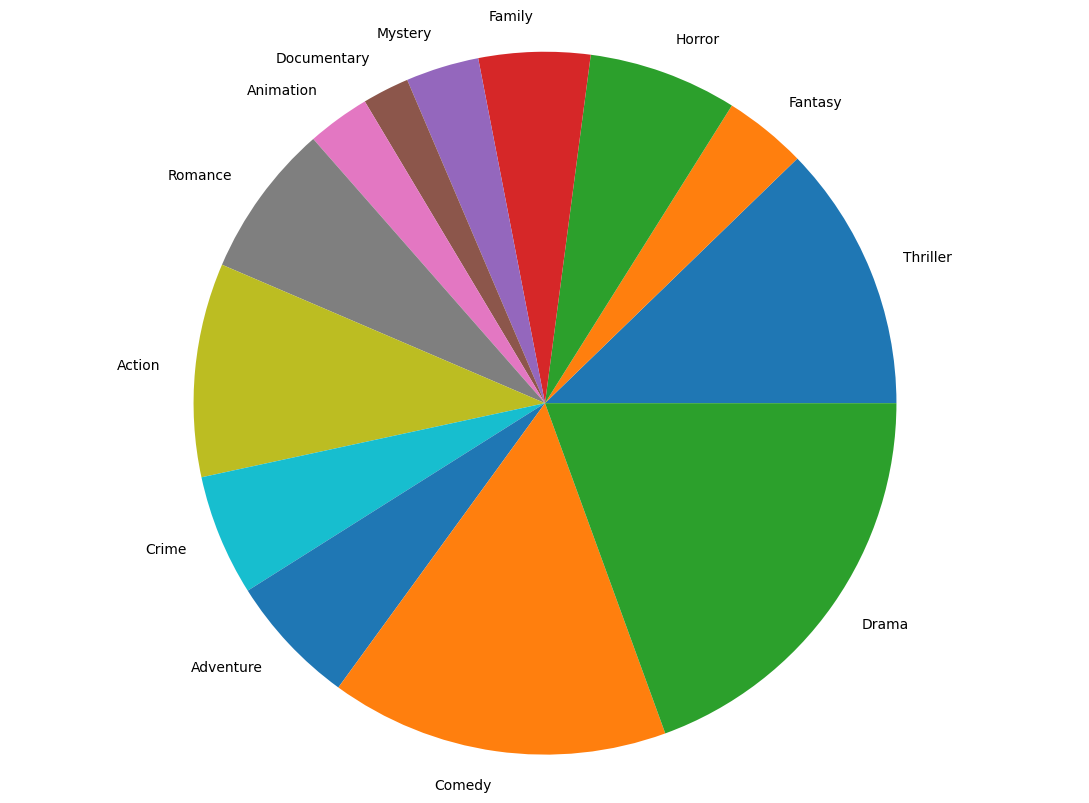

In [46]:
fig_pie,ax_pie = plt.subplots(figsize=(11,8))
plt.pie(data,radius=4.0,labels=labels)
plt.axis('equal')
plt.tight_layout()
plt.show()

# Content based Recommender

In [6]:
combined = pd.concat([train, test], ignore_index=True)
new_df = combined[["imdb_id", "original_title", "keywords"]].dropna()
new_df.drop_duplicates(subset=['imdb_id'], keep=False, inplace=True)

In [7]:
print(new_df.columns)


Index(['imdb_id', 'original_title', 'keywords'], dtype='object')


In [8]:
new_df.head()

,imdb_id,original_title,keywords
0,tt0110763,The Pagemaster,"[library, adventure, part animated]"
1,tt3983674,The Mask You Live In,"[feminism, sexism, young boy, gender roles, mi..."
2,tt1397514,Journey 2: The Mysterious Island,"[mission, mysterious island, missing person, d..."
3,tt0109484,"Corrina, Corrina","[loss of mother, daughter, friendship, mute, h..."
4,tt0472033,9,"[man vs machine, hope, post-apocalyptic, dysto..."


In [9]:
# Convert each entry in keywords to a string and lowercase safely
def clean_keywords_entry(x):
    if isinstance(x, list):
        # join list elements with space
        x = " ".join(map(str, x))
    elif not isinstance(x, str):
        x = str(x)
    return x.lower()

new_df['keywords'] = new_df['keywords'].fillna('').apply(clean_keywords_entry)
new_df.head()


,imdb_id,original_title,keywords
0,tt0110763,The Pagemaster,library adventure part animated
1,tt3983674,The Mask You Live In,feminism sexism young boy gender roles misogyny
2,tt1397514,Journey 2: The Mysterious Island,mission mysterious island missing person durin...
3,tt0109484,"Corrina, Corrina",loss of mother daughter friendship mute housek...
4,tt0472033,9,man vs machine hope post-apocalyptic dystopia ...


In [10]:
new_df.shape

(10854, 3)

In [11]:
import nltk
from nltk.stem import PorterStemmer

## Porter Stemmer algorithm

In [12]:
ps = PorterStemmer()

In [13]:
def stems(text):
    l = []
    for i in text.split():
        l.append(ps.stem(i))

    return " ".join(l)

In [14]:
new_df['keywords'] = new_df['keywords'].apply(stems)

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=5000, stop_words= 'english')

In [16]:
vector = cv.fit_transform(new_df['keywords']).toarray()

In [17]:
vector

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [18]:
vector.shape

(10854, 5000)

## Similarity model

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

In [20]:
similarity = cosine_similarity(vector)

In [21]:
similarity

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [22]:
similarity.shape

(10854, 10854)

In [23]:
new_df[new_df['original_title'] == 'Spider-Man'].index[0]

np.int64(2130)

In [24]:
def recommend(movie):
    index = new_df[new_df['original_title'] == movie].index[0]
    distances = sorted(list(enumerate(similarity[index])), reverse=True, key = lambda x: x[1])
    for i in distances[1:6]:
        print(new_df.iloc[i[0]].original_title)

In [32]:
recommend('Spider-Man')

Find Me Guilty
Underclassman
The Revenant
Police Academy 4: Citizens on Patrol
Mad Dog and Glory


In [26]:
import pickle

pickle.dump(new_df, open('/content/movie_list.pkl', 'wb'))
pickle.dump(similarity, open('/content/similarity.pkl', 'wb'))